# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts    

In [367]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training

from sklearn import preprocessing, linear_model, neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn import metrics

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [368]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [383]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    "surprised" # in TESS specifies pleasant surprise
}

# map emotion to 2D space
circumplex_model = {
    "neutral":(0.0, 0.0),
    "calm":(0.5,-0.7), # only included in RAVDESS
    "happy":(0.8, 0.1),
    "sad":(-0.8, -0.3),
    "angry":(-0.2,0.7),
    "fearful":(-0.4,0.7), #circumplex afraid
    "disgust":(-0.41,0.6), #circumplex annoyed
    "surprised":(0.3,0.7), #circumplex astonished, in TESS specifies pleasant surprise
}

# map emotion to 3d space
pad_model = {
    
}

In [384]:
# load data and extract features
def load_data(test_size=0.2):
    X, y = [], []
    
    # RAVDESS clean
    for file in glob.glob("data/RAVDESS-nosil/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only circumplex model emotions
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # map coords
        circumplex_coord = circumplex_model[emotion]
        # extract features
        features = extract_feature(file, mfcc=True)
        # add to data
        X.append(features)
        y.append(circumplex_coord)
    
#     # augmented RAVDESS
#     # white noise
#     for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = int2emotion[basename.split("-")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
        
    # CREMA-D clean
    for file in glob.glob("data/CREMA-D/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = cemotion[basename.split("_")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # map coords
        circumplex_coord = circumplex_model[emotion]
        # extract features
        features = extract_feature(file, mfcc=True)
        # add to data
        X.append(features)
        y.append(circumplex_coord)

#     # TESS clean
#     for file in glob.glob("data/TESS-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = tessemotion[basename.split("_")[2]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # emodb clean
#     for file in glob.glob("data/EMODB-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = char2emotion[basename[5]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)
    
#     # SAVEE clean
#     for file in glob.glob("data/SAVEE-nosil/*.wav"):
#         # get the base name of the audio file
#         basename = os.path.basename(file)
#         # get the emotion label
#         emotion = saveeemotion[basename[0]]
#         # we allow only AVAILABLE_EMOTIONS we set
#         if emotion not in AVAILABLE_EMOTIONS:
#             continue
#         # extract features
#         features = extract_feature(file, mfcc=True)
#         # add to data
#         X.append(features)
#         y.append(emotion)

    # scale features [1, -1]
    #X /= np.max(np.abs(X),axis=0)
    
#     # label encoding for y
#     label_encoder = preprocessing.LabelEncoder()
#     label_encoder.fit(y)
#     print("Class mapping: ")
#     for i, item in enumerate(label_encoder.classes_):
#         print(item, "-->", i)
        
#     encoded_labels = label_encoder.transform(y)
    #print("Labels =", labels)
    #print("Encoded labels =", list(encoded_labels))
    
    # split the data to training and testing and return it
    return train_test_split(np.array(X), np.array(y), test_size=test_size, random_state=420, stratify=y)

In [385]:
# load dataset(s), 80% training 20% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.2)

In [386]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 7105
[+] Number of testing samples: 1777
[+] Number of features: 13


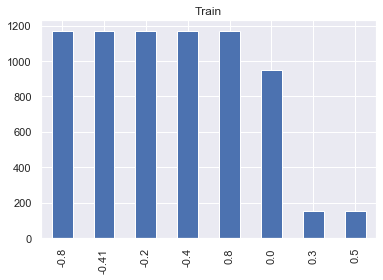

In [387]:
y_train_df = pd.DataFrame(data=y_train[:,0], columns=['label'])
y_train_df['label'].value_counts().plot.bar(title='Train')

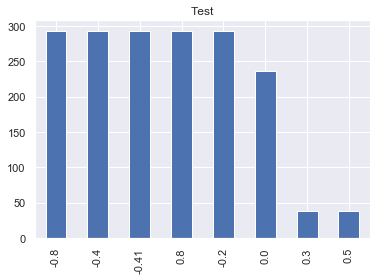

In [388]:
y_test_df = pd.DataFrame(data=y_test[:,0], columns=['label'])
y_test_df['label'].value_counts().plot.bar(title='Test')

In [389]:
regr_params = {
    'verbose': 10,
    'n_estimators': 100,
    'max_depth':None,
}

In [390]:
# init regr
regr = RandomForestRegressor(**regr_params)

In [391]:
# train the model
print("[*] Training the model...")
regr.fit(X_train, y_train)

[*] Training the model...
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=10, warm_start=False)

In [392]:
y_predict = regr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


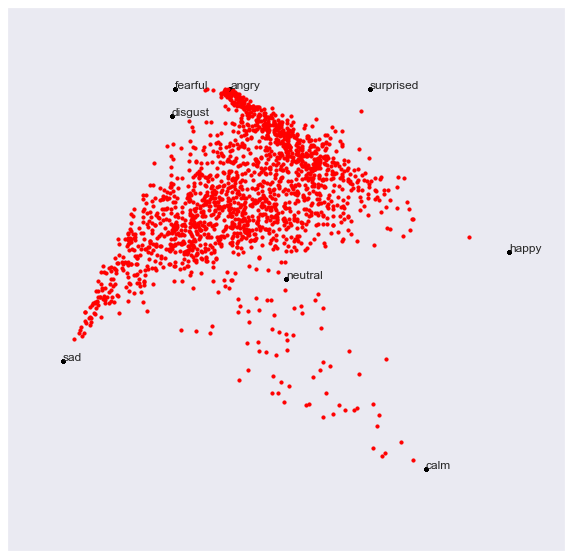

      Actual x  Actual y  Predicted x  Predicted y
0        -0.41       0.6      -0.4900        0.118
1        -0.40       0.7       0.0365        0.429
2        -0.41       0.6       0.0615        0.308
3        -0.80      -0.3      -0.3451        0.460
4        -0.80      -0.3      -0.4776        0.106
...        ...       ...          ...          ...
1772     -0.20       0.7       0.1908        0.341
1773     -0.80      -0.3      -0.1500        0.179
1774     -0.41       0.6      -0.3576        0.104
1775     -0.41       0.6      -0.1178        0.216
1776     -0.20       0.7      -0.2067        0.669

[1777 rows x 4 columns]

Mean Absolute Error: 0.32607523916713516
Mean Squared Error: 0.16076376287438254
Root Mean Squared Error: 0.40095356698049534


In [393]:
#Plot outputs
plt.figure(figsize=(10,10))
# im = plt.imread("circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])
plt.scatter(y_test[:,0], y_test[:,1], color='black', s=10)
plt.scatter(y_predict[:,0],y_predict[:,1], color='red', s=10)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks(())
plt.yticks(())

for key, value in circumplex_model.items():
    plt.annotate(key, value)

plt.show()

df_regr = pd.DataFrame({'Actual x': y_test[:,0], 
                        'Actual y':y_test[:,1],
                        'Predicted x': y_predict[:,0], 
                        'Predicted y':y_predict[:,1]})
print(df_regr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

In [10]:
# best model params, determined by a grid search
clf_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction':0.1,
    'verbose': 10,
    'n_iter_no_change': 10,
}

In [11]:
# init MLP classifier
clf = MLPClassifier(**clf_params)

In [12]:
# train the model
print("[*] Training the model...")
clf.fit(X_train, y_train)

[*] Training the model...
Iteration 1, loss = 1.75201689
Validation score: 0.305369
Iteration 2, loss = 1.67492984
Validation score: 0.328859
Iteration 3, loss = 1.61095321
Validation score: 0.337248
Iteration 4, loss = 1.56832926
Validation score: 0.327181
Iteration 5, loss = 1.54642222
Validation score: 0.345638
Iteration 6, loss = 1.53109893
Validation score: 0.337248
Iteration 7, loss = 1.52134136
Validation score: 0.355705
Iteration 8, loss = 1.51146446
Validation score: 0.355705
Iteration 9, loss = 1.50450428
Validation score: 0.357383
Iteration 10, loss = 1.49738540
Validation score: 0.348993
Iteration 11, loss = 1.49188943
Validation score: 0.365772
Iteration 12, loss = 1.48740182
Validation score: 0.355705
Iteration 13, loss = 1.48002720
Validation score: 0.372483
Iteration 14, loss = 1.47545064
Validation score: 0.367450
Iteration 15, loss = 1.47109107
Validation score: 0.374161
Iteration 16, loss = 1.46742548
Validation score: 0.365772
Iteration 17, loss = 1.46304683
Validat

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [13]:
# classifier stats
print("Score/Accuracy:")
print(clf.score(X_test, y_test))

print("No. of layers:")
print(clf.n_layers_)

print("No. of epochs:")
print(clf.n_iter_)

print("Loss:")
print(clf.loss_)

print("Validation score:")
print(clf.validation_scores_[clf.n_iter_-1])

print("Out Activation:")
print(clf.out_activation_)

Score/Accuracy:
0.39422431161853594
No. of layers:
3
No. of epochs:
48
Loss:
1.3926419239507533
Validation score:
0.39932885906040266
Out Activation:
softmax


['neutral']
[[0.12525466 0.20276873 0.15856133 0.17348136 0.24855758 0.09137633]]
['disgust']
[[0.06698763 0.46759975 0.06540839 0.21156913 0.10219468 0.08624042]]
['neutral']
[[0.12545815 0.12680238 0.08641836 0.18063254 0.40547368 0.07521489]]
['angry']
[[0.44944885 0.08735933 0.06895323 0.36856424 0.02283627 0.00283808]]


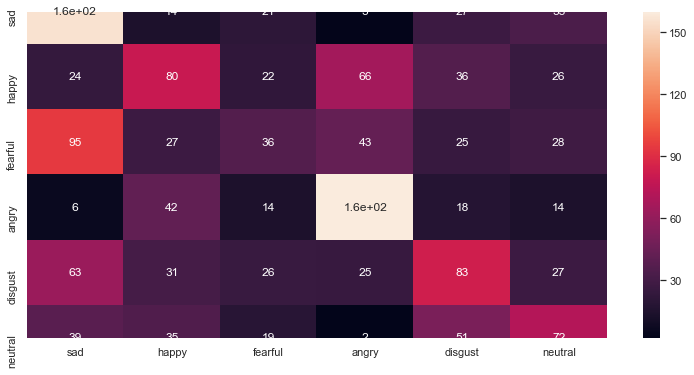

Accuracy: 39.42%


In [19]:
# clf predict
y_pred = clf.predict(X_test)

print(clf.predict(X_test[[1]]))
print(clf.predict_proba(X_test[[1]]))

print(clf.predict(X_test[[30]]))
print(clf.predict_proba(X_test[[30]]))

print(clf.predict(X_test[[22]]))
print(clf.predict_proba(X_test[[22]]))

print(clf.predict(X_test[[1337]]))
print(clf.predict_proba(X_test[[1337]]))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=list(AVAILABLE_EMOTIONS))
x_axis_labels = y_axis_labels = AVAILABLE_EMOTIONS

# plot cm dataframe
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(13,6))
sn.set(font_scale=1) # for labels
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

In [56]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(clf, open("result/mlp_classifier.model", "wb"))
pickle.dump(reg, open("result/reg.model", "wb"))

NameError: name 'model' is not defined